# Trabalho Final - Detecção de Fraude em Pagamentos On-line
Disponível em https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

## Objetivo
Existem várias maneiras pelas quais os criminosos podem roubar informações de cartão de crédito ou débito, como phishing, keyloggers, malware, engenharia social e ataques de força bruta.
Os clientes desejam identificar e prevenir atividades fraudulentas em seu site para garantir uma experiência online segura e confiável para seus clientes. Portanto, desenvolver um sistema robusto e preciso que possa identificar e prevenir atividades fraudulentas em transações de pagamento online.

## Descrição do dataset
**Variable: Definition**

**step:** representa uma unidade de tempo onde 1 passo equivale a 1 hora

**type:** tipo de transação online

**amount:** o valor da transação

**nameOrig:** cliente iniciando a transação

**oldbalanceOrig:** saldo antes da transação

**newbalanceOrig:** saldo após a transação

**nameDest:** destinatário da transação

**oldbalanceDest:** saldo inicial do destinatário antes da transação

**newbalanceDest:** o novo saldo do destinatário após a transação

**isFraud:** transação fraudulenta

### Importando bibliotecas utilizadas

In [73]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
## import warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=DataConversionWarning, module='sklearn')

### Importando Dataset

In [74]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Quantidade de tuplas e quantidade de espaço ocupado pelo dataset

In [75]:
num_tuplas = df.shape[0]
print(f"Número de tuplas: {num_tuplas}")
espaco_armazenamento = df.memory_usage().sum()
print(f"Espaço de armazenamento: {espaco_armazenamento/1000000} MB")

Número de tuplas: 6362620
Espaço de armazenamento: 559.910688 MB


## Análise dos dados
### Verificando se há dados NULL ou NaN

In [76]:
print("Dados nulos:")
print(df.isnull().sum())
print("Dados NaN:")
print(df.isna().sum())

Dados nulos:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Dados NaN:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


### Verificando a coluna 'isFlaggedFraud'

In [77]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

### Excluindo colunas que não são necessárias

In [78]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [79]:
def plot_count_column(coluna, titulo):
    coluna = coluna.value_counts()
    namesCol = coluna.index
    qtdCol = coluna.values
    return px.pie(df,values=qtdCol,names=namesCol,hole=0.5,title=titulo)

### Gráfico de contagem da coluna 'type'

In [80]:
plot_count_column(df['type'], "Distribuição dos tipos de transações")

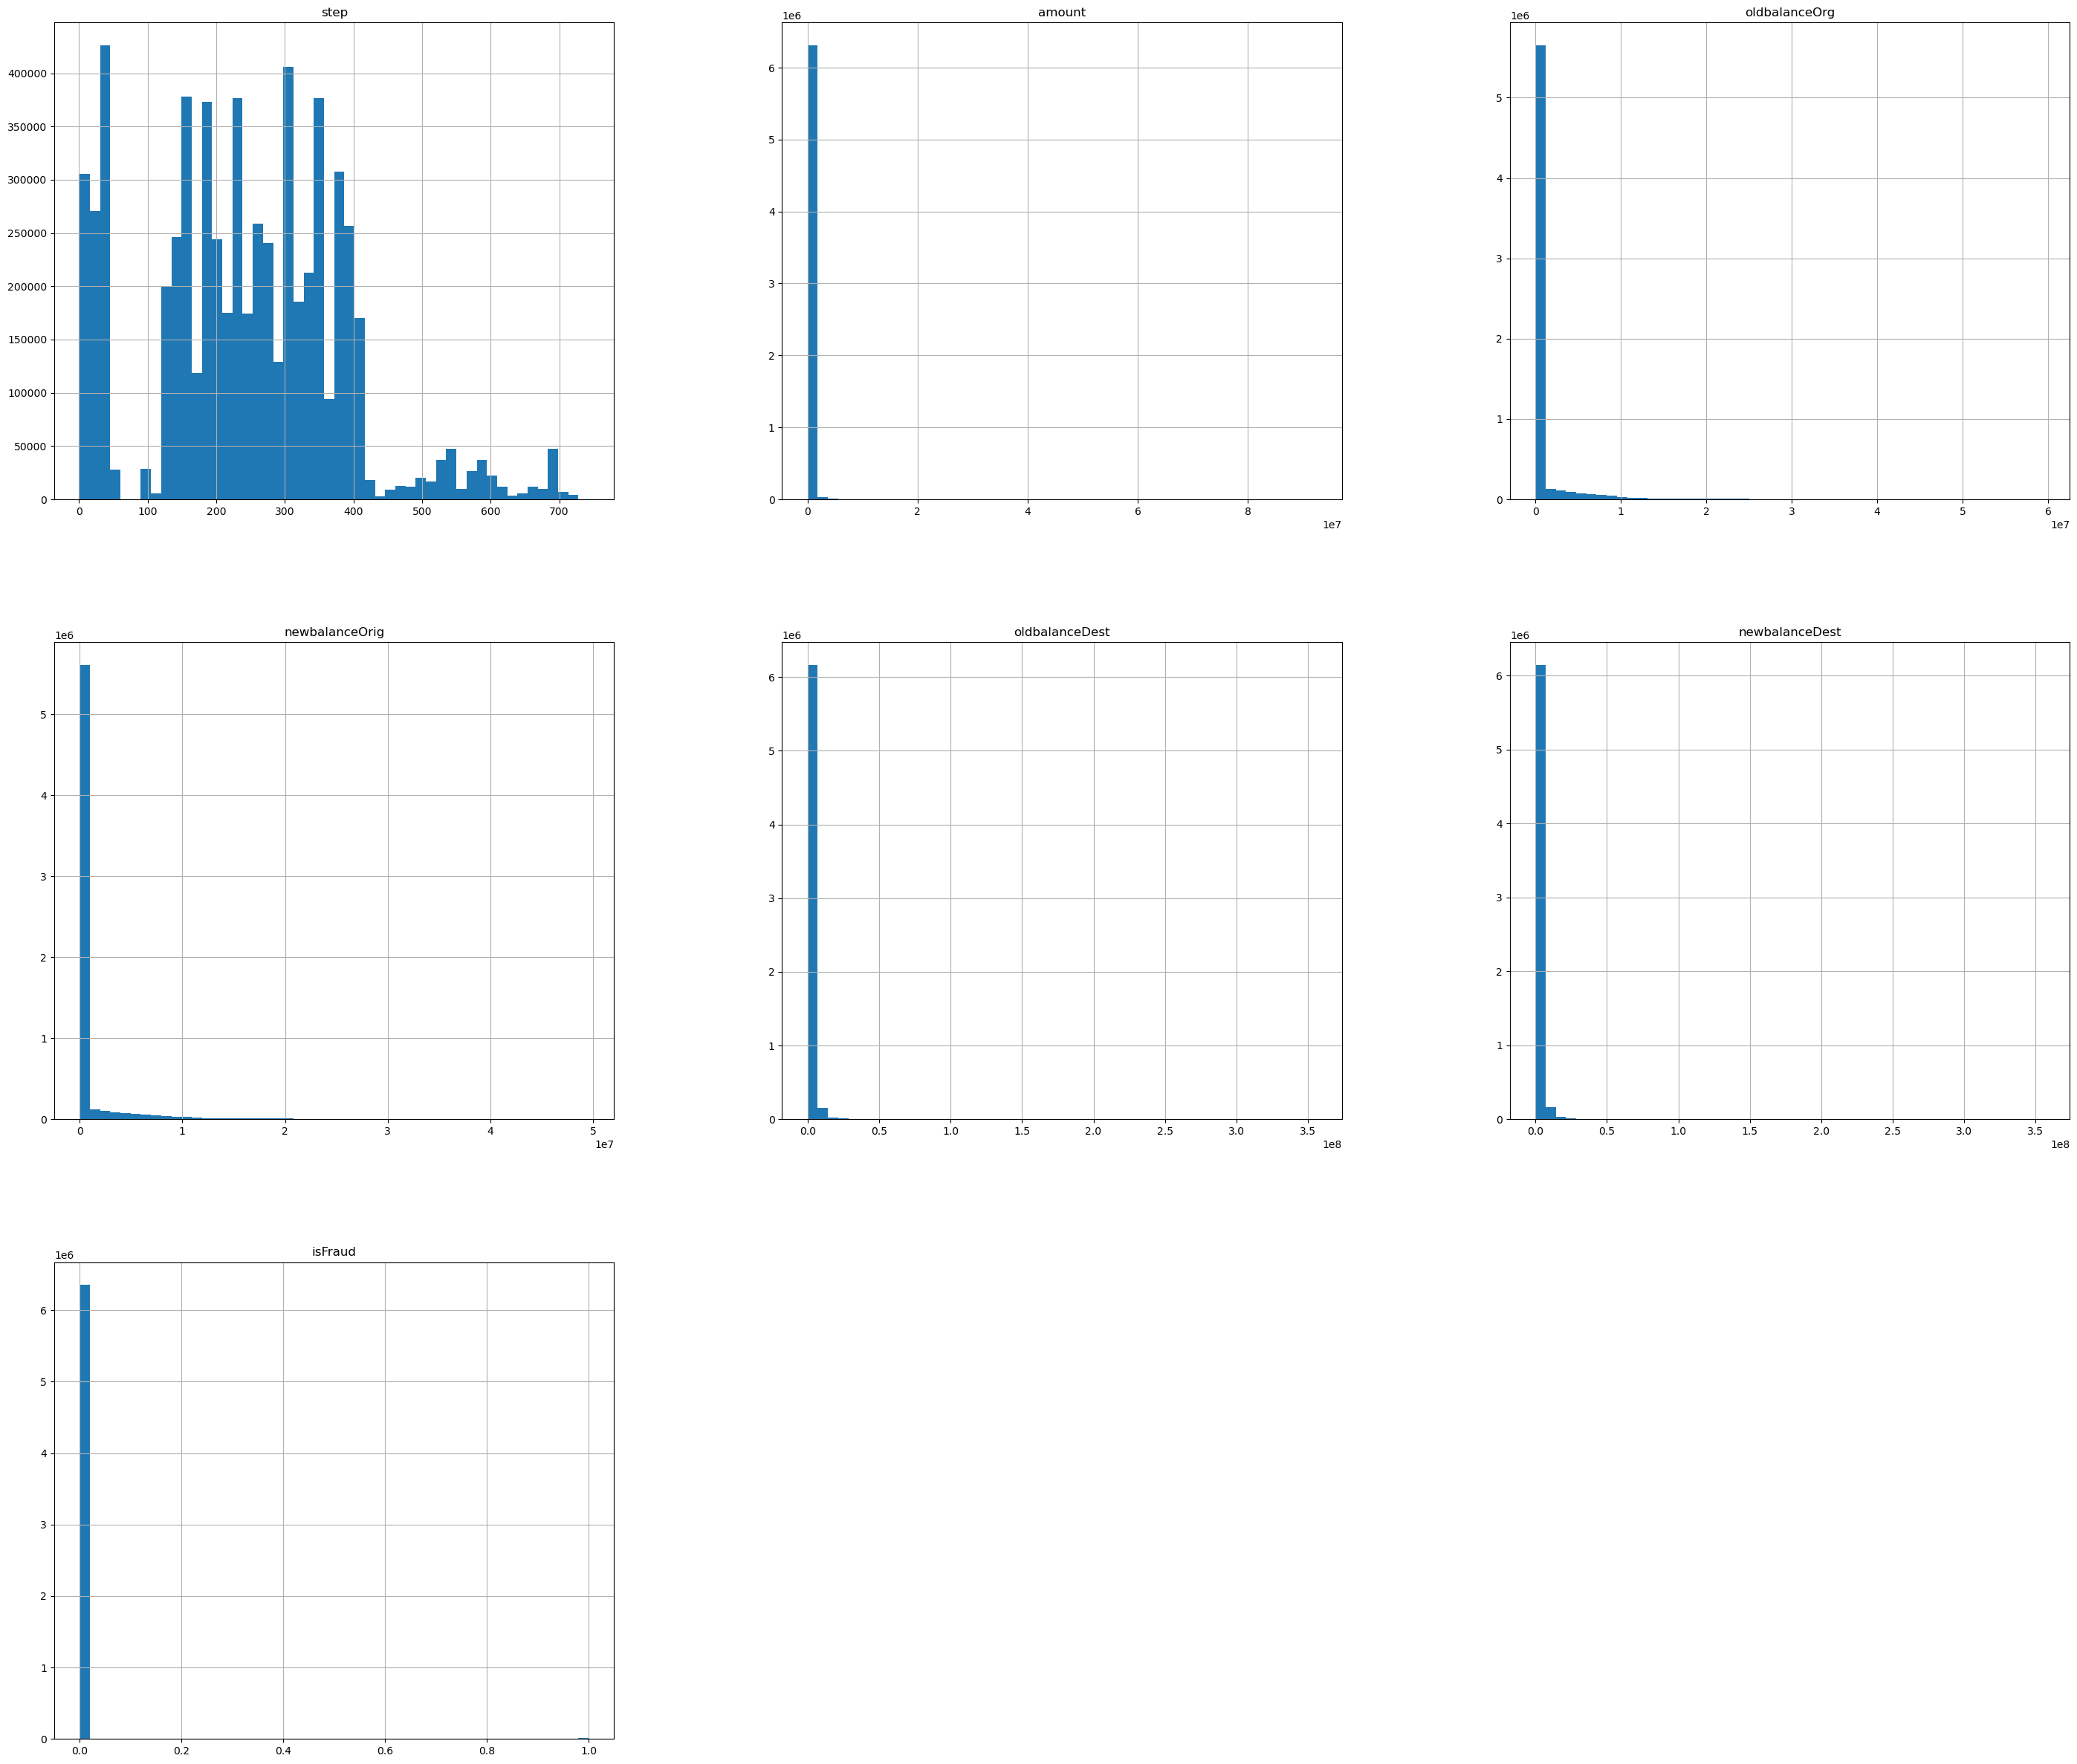

In [81]:
df.hist(figsize = (35,30), bins = 50)
plt.show()

### Correlação com a coluna 'isFraud'

In [82]:
correlation = df.corr()
print(correlation['isFraud'].sort_values(ascending=False))

isFraud           1.000000
amount            0.076688
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


### Matriz de correlação

In [83]:
corr = df.corr()
# esta célula não é necessária para resolver a questão, mas dá uma boa ideia visual das correlações.
corr.style.background_gradient(cmap='RdYlGn', axis=None).format(precision=2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.00,0.02,-0.01,-0.01,0.03,0.03,0.03
amount,0.02,1.00,-0.00,-0.01,0.29,0.46,0.08
oldbalanceOrg,-0.01,-0.00,1.00,1.00,0.07,0.04,0.01
newbalanceOrig,-0.01,-0.01,1.00,1.00,0.07,0.04,-0.01
oldbalanceDest,0.03,0.29,0.07,0.07,1.00,0.98,-0.01
newbalanceDest,0.03,0.46,0.04,0.04,0.98,1.00,0.00
isFraud,0.03,0.08,0.01,-0.01,-0.01,0.00,1.00


## Pré-processamento de dados

### Aplicando one-hot-encoder na coluna 'type'

In [84]:
X = df.drop('isFraud',axis=1)
X = pd.get_dummies(data=X,columns=['type'],drop_first=True)
y = df['isFraud']
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0


### Gráfico de contagem da coluna 'isFraud'

In [85]:
plot_count_column(y, "Distribuição das ocorrências de fraude")

### SMOTE - Synthetic Minority Oversampling Technique

In [86]:
from imblearn.over_sampling import SMOTE

# Aplica o SMOTE para balanceamento
smote = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=3) # Default: k_neighbors=5
X_smote, y_smote = smote.fit_resample(X, y)

plot_count_column(y_smote, "Distribuição das ocorrências de fraude - SMOTE")

### Funções para visualização gráfica

In [87]:
from sklearn import tree
import graphviz
def plot_decision_tree(model, nomes_colunas, nomes_classes):
    tree.export_graphviz(model, out_file='DecisionTree.dot',
                       feature_names=nomes_colunas, 
                       class_names=nomes_classes,
                       label='all',
                       rounded=True,
                       filled=True)
    graph = graphviz.Source(open("DecisionTree.dot", "r").read())
    return graph

def plot_confusion_matrix(matrix, labels):
    plt.figure(figsize=(len(labels)+2, len(labels)+2))
    sns.heatmap(matrix, annot=True, fmt="d", cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Verdadeira')
    plt.title('Matriz de Confusão')
    plt.show()
    
# Adicionando os valores acima das barras
def plot_classification_report(report, labels):
    # Obtendo as métricas para cada classe
    precision = [report[str(i)]['precision'] for i in range(len(report) - 3)]
    recall = [report[str(i)]['recall'] for i in range(len(report) - 3)]
    f1_score = [report[str(i)]['f1-score'] for i in range(len(report) - 3)]

    # Plotando o gráfico de barras
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, precision, width, label='Precision')
    rects2 = ax.bar(x, recall, width, label='Recall')
    rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

    ax.set_ylabel('Scores')
    ax.set_title('Desempenho por Classe')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Adicionando os valores acima das barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.ylim(0, 1.2)
    plt.tight_layout()
    plt.show()

# Modelos preditivos de classificação

### Separando treino e teste: 80-20%

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.2,random_state=42)

### Verificando estratificação do conjunto de  dados

In [89]:
def print_perc_class(y):
    values, counts = np.unique(y, return_counts=True)
    total_size = y.shape[0]
    for i in range(values.shape[0]):
        print('class: {}, count: {}, perc: {}'.format(int(values[i]), counts[i], (counts[i]/total_size).round(4)))

In [90]:
print_perc_class(y_smote)

class: 0, count: 6354407, perc: 0.5
class: 1, count: 6354407, perc: 0.5


In [91]:
print_perc_class(y_train)

class: 0, count: 5083570, perc: 0.5
class: 1, count: 5083481, perc: 0.5


In [92]:
print_perc_class(y_test)

class: 0, count: 1270837, perc: 0.5
class: 1, count: 1270926, perc: 0.5


In [93]:
models = ["DecisionTree", 'Knn', 'LogisticRegression', 'Perceptron', 'RandomForest'] 
data = {'Modelos': models, 'Accuracy': 0, 'Precision': 0,'Recall': 0, 'F1': 0}
results = pd.DataFrame(data)
results.set_index('Modelos', inplace=True)

## Utilizando o modelo Árvore de decisão
### Sem definir o hiperparâmetro max_depth

In [94]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
results.loc['DecisionTree', 'Accuracy'] = accuracy_score(y_test, y_pred)
results.loc['DecisionTree', 'Precision'] = precision_score(y_test, y_pred)
results.loc['DecisionTree', 'Recall'] = recall_score(y_test, y_pred)
results.loc['DecisionTree', 'F1'] = f1_score(y_test, y_pred)
print(f"Accuracy: {results.loc['DecisionTree', 'Accuracy']}")
print(f"Precision: {results.loc['DecisionTree', 'Precision']}")
print(f"Recall: {results.loc['DecisionTree', 'Recall']}")
print(f"F1: {results.loc['DecisionTree', 'F1']}")

Accuracy: 0.9997297151622713
Precision: 0.9995815317040863
Recall: 0.9998780416798461
F1: 0.9997297647064841


In [95]:
max_depth = dt.tree_.max_depth
print(f"Valor do max_depth: {max_depth}")
feature_importances = dt.feature_importances_
nomes_atributos = X.columns
# Imprimir as importâncias dos recursos com os nomes correspondentes
for nome, importancia in zip(nomes_atributos, feature_importances):
    print(f"Atributo {nome}: {importancia}")

Valor do max_depth: 37
Atributo step: 0.038080958210769
Atributo amount: 0.1559096639856378
Atributo oldbalanceOrg: 0.3320413023887794
Atributo newbalanceOrig: 0.36790065752852513
Atributo oldbalanceDest: 0.0022739201140248902
Atributo newbalanceDest: 0.050983367946250475
Atributo type_CASH_OUT: 0.011033988590713799
Atributo type_DEBIT: 0.0005980203895593786
Atributo type_PAYMENT: 0.023491940736372893
Atributo type_TRANSFER: 0.017686180109367206


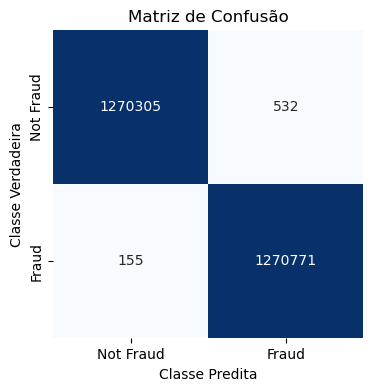

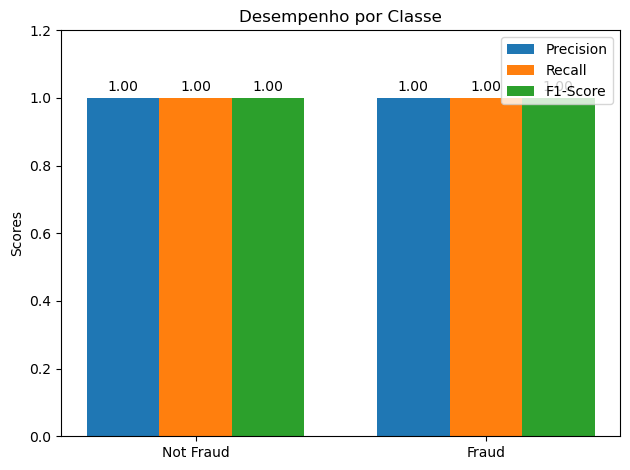

In [96]:
y_pred = dt.predict(X_test) 
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['Not Fraud', 'Fraud'])
report = classification_report(y_test, y_pred, output_dict=True)
plot_classification_report(report, ['Not Fraud', 'Fraud'])

### Verificando overfiting
#### <span style="color: red;">Modelo superajustado? Talvez</span>

In [97]:
def verify_overfit(model, X_train, y_train, X_test, y_test):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    acc_train = accuracy_score(y_train, pred_train)
    acc_test = accuracy_score(y_test, pred_test)
    print(acc_train)
    print(acc_test)
    diff_error = acc_train - acc_test 
    return diff_error

diff_error = verify_overfit(dt, X_train, y_train, X_test, y_test)
print(f"Diferença entre erro de treinamento e erro de validação: {diff_error}")

1.0
0.9997297151622713
Diferença entre erro de treinamento e erro de validação: 0.00027028483772872924


## Modelos preditivos (KNN, LogisticRegression, Percetron, RandomForest)

Acurácia do modelo Knn: 0.9931575052434078
Precisão do modelo Knn: 0.9879424839043682
Recall do modelo Knn: 0.9985018797317862
F1 do modelo Knn: 0.9931941163856187


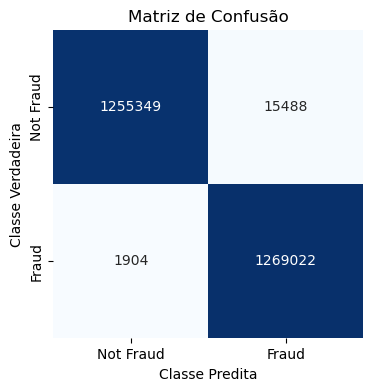

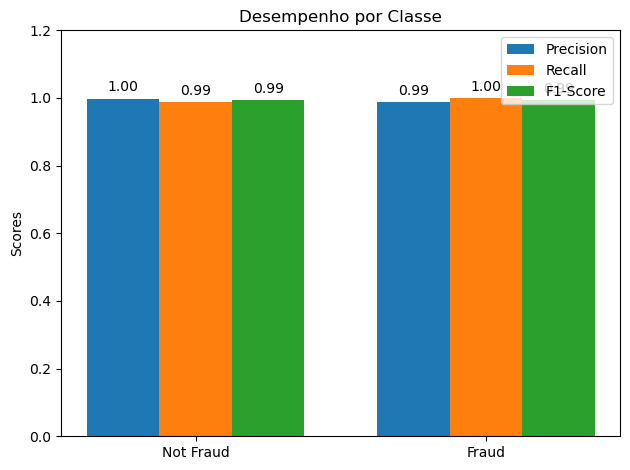

Acurácia do modelo LogisticRegression: 0.9534547477479214
Precisão do modelo LogisticRegression: 0.9529485181368977
Recall do modelo LogisticRegression: 0.9540169923347229
F1 do modelo LogisticRegression: 0.9534824559023655


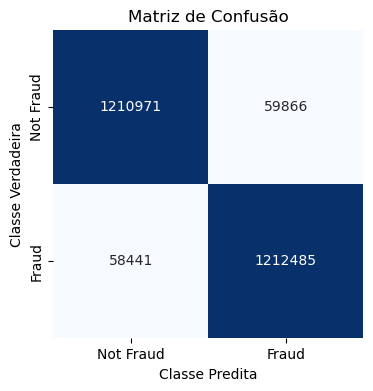

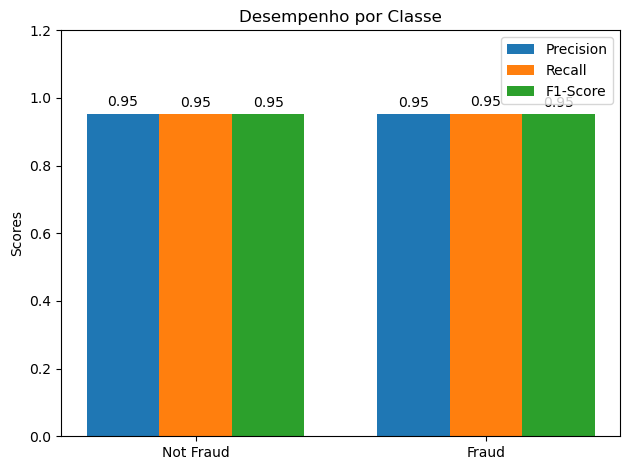

Acurácia do modelo Perceptron: 0.9297330238893241
Precisão do modelo Perceptron: 0.9574979770514709
Recall do modelo Perceptron: 0.8993938278074411
F1 do modelo Perceptron: 0.927536831650389


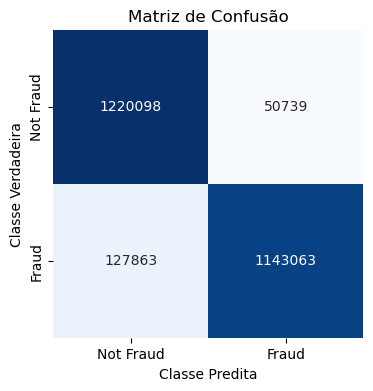

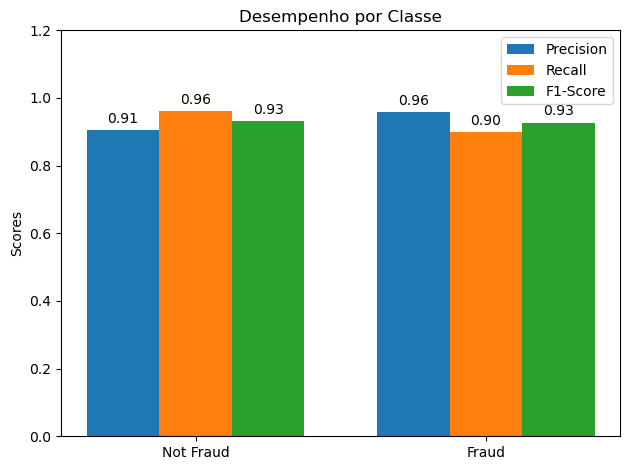

Acurácia do modelo RandomForest: 0.9997604025237601
Precisão do modelo RandomForest: 0.99953283707103
Recall do modelo RandomForest: 0.9999881975819206
F1 do modelo RandomForest: 0.9997604654757593


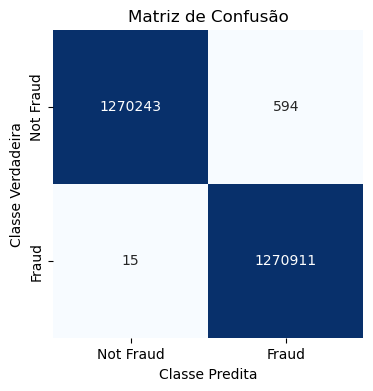

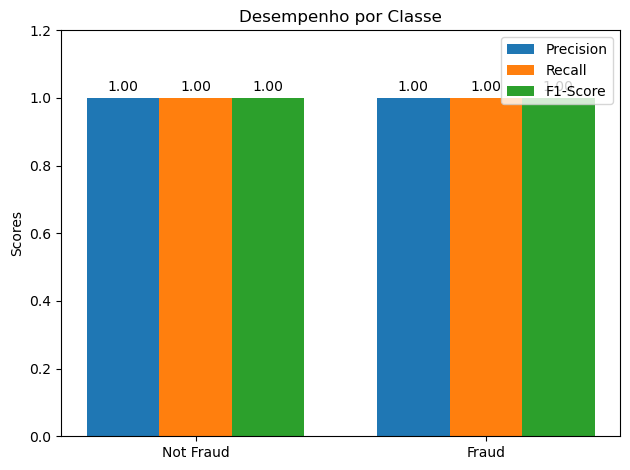

In [98]:
pipeline_knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

pipeline_rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)

# Crie um pipeline para o modelo Decision Tree:
pipeline_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

pipeline_pc = make_pipeline(
    StandardScaler(),
    Perceptron()
)


# Treine e avalie cada pipeline separadamente:
pipelines = [
    ('Knn', pipeline_knn),
    ('LogisticRegression', pipeline_lr),
    ('Perceptron', pipeline_pc),
    ('RandomForest', pipeline_rf)
]



for model_name, pipeline in pipelines:
    # Treine o pipeline usando os dados de treinamento:
    pipeline.fit(X_train, y_train)
    
    # Avalie o desempenho do modelo no pipeline usando os dados de teste:
    y_pred = pipeline.predict(X_test)
    results.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    results.loc[model_name, 'Precision'] = precision_score(y_test, y_pred)
    results.loc[model_name, 'Recall'] = recall_score(y_test, y_pred)
    results.loc[model_name, 'F1'] = f1_score(y_test, y_pred)
    print(f"Acurácia do modelo {model_name}: {results.loc[model_name, 'Accuracy']}")
    print(f"Precisão do modelo {model_name}: {results.loc[model_name, 'Precision']}")
    print(f"Recall do modelo {model_name}: {results.loc[model_name, 'Recall']}")
    print(f"F1 do modelo {model_name}: {results.loc[model_name, 'F1']}")
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['Not Fraud', 'Fraud'])
    report = classification_report(y_test, y_pred, output_dict=True)
    plot_classification_report(report, ['Not Fraud', 'Fraud'])
    


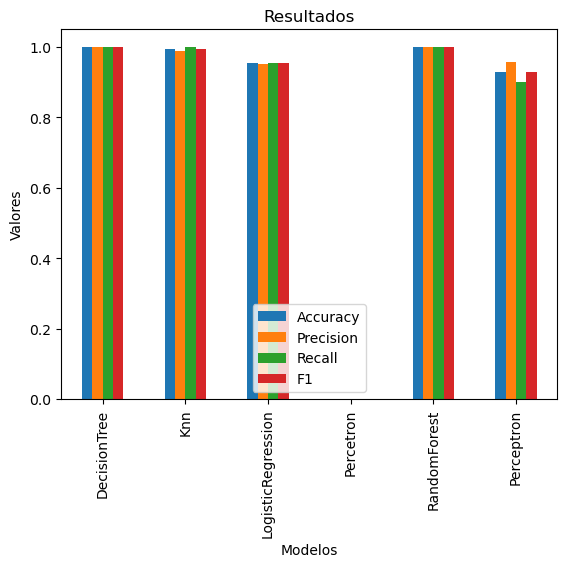

In [99]:
results.plot(kind='bar')
plt.xlabel('Modelos')
plt.ylabel('Valores')
plt.title('Resultados')
plt.show()

In [100]:
from tabulate import tabulate
# Converter o dataframe em uma tabela formatada
table = tabulate(results, headers='keys', tablefmt='fancy_grid')

# Exibir a tabela
print(table)

╒════════════════════╤════════════╤═════════════╤══════════╤══════════╕
│ Modelos            │   Accuracy │   Precision │   Recall │       F1 │
╞════════════════════╪════════════╪═════════════╪══════════╪══════════╡
│ DecisionTree       │   0.99973  │    0.999582 │ 0.999878 │ 0.99973  │
├────────────────────┼────────────┼─────────────┼──────────┼──────────┤
│ Knn                │   0.993158 │    0.987942 │ 0.998502 │ 0.993194 │
├────────────────────┼────────────┼─────────────┼──────────┼──────────┤
│ LogisticRegression │   0.953455 │    0.952949 │ 0.954017 │ 0.953482 │
├────────────────────┼────────────┼─────────────┼──────────┼──────────┤
│ Percetron          │   0        │    0        │ 0        │ 0        │
├────────────────────┼────────────┼─────────────┼──────────┼──────────┤
│ RandomForest       │   0.99976  │    0.999533 │ 0.999988 │ 0.99976  │
├────────────────────┼────────────┼─────────────┼──────────┼──────────┤
│ Perceptron         │   0.929733 │    0.957498 │ 0.899394 │ 0.9